In [1]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import os
import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS
from rdkit.Chem.rdMolAlign import AlignMolConformers, AlignMol
from rdkit.Chem.Draw import rdMolDraw2D
from conf_ensemble_library import ConfEnsembleLibrary
from pdbbind_metadata_processor import PDBBindMetadataProcessor
from molconfviewer import MolConfViewer
from litschnet import LitSchNet
from molecule_featurizer import MoleculeFeaturizer
from torch_geometric.data import Batch
from ConfScorer import ConfAnalyzer
from sklearn.metrics import r2_score
from energy_calculator import XtbEnergyCalculator
from rdkit.Chem.rdMolTransforms import SetDihedralDeg, GetDihedralDeg
from collections import namedtuple

In [2]:
def get_model() :
    split = 'random'
    iteration = 0
    experiment_name = f'{split}_split_{iteration}'
    checkpoint_name = os.listdir(os.path.join('lightning_logs', experiment_name, 'checkpoints'))[0]
    checkpoint_path = os.path.join('lightning_logs', experiment_name, 'checkpoints', checkpoint_name)
    model = LitSchNet.load_from_checkpoint(checkpoint_path=checkpoint_path)
    model.eval()
    return model

In [3]:
def save_2d_depiction(mol, path, atom_indices=False) :
    d2d = rdMolDraw2D.MolDraw2DCairo(700, 700)
    if atom_indices :
        d2d.drawOptions().addAtomIndices=True
    mol_copy = copy.deepcopy(mol)
    mol_copy.RemoveAllConformers()
    d2d.DrawMolecule(mol_copy)
    d2d.FinishDrawing()
    d2d.WriteDrawingText(path) 

In [4]:
def get_most_similar_mol_in_train(test_mol, train_fps) :
    test_fp = AllChem.GetMorganFingerprint(test_mol, 3, useChirality=True)
    sims = []
    for train_fp in train_fps :
        dice_sim = DataStructs.TanimotoSimilarity(test_fp, train_fp)
        sims.append(dice_sim)
    max_sim_idx = np.argmax(sims)
    print('Tanimoto similarity: ', np.max(sims))
    sim_smiles = train_smiles[max_sim_idx]

    sim_ce = cel.load_ensemble_from_smiles(sim_smiles, load_dir='merged')
    return sim_ce.mol

In [5]:
split = 'random'
iteration = 0
with open(os.path.join('data/', f'ligand_{split}_splits', f'train_smiles_{split}_split_{iteration}.txt'), 'r') as f :
    train_smiles = f.readlines()
    train_smiles = [smiles.strip() for smiles in train_smiles]

In [6]:
train_mols = [Chem.MolFromSmiles(smiles) for smiles in train_smiles]
train_fps = [AllChem.GetMorganFingerprint(mol, 3, useChirality=True) for mol in train_mols]

In [7]:
mcv = MolConfViewer()
mf = MoleculeFeaturizer()
ca = ConfAnalyzer()
xtb_calculator = XtbEnergyCalculator()

In [8]:
# look at the bioactive conformation identification performance of highly flexible molecules

mol_results_path = 'results/random_split_0_pdbbind/mol_results.p'
with open(mol_results_path, 'rb') as f :
    mol_results = pickle.load(f)

conf_results_path = 'results/random_split_0_pdbbind/conf_results.p'
with open(conf_results_path, 'rb') as f :
    conf_results = pickle.load(f)

In [10]:
results

{'n_rotatable_bonds': 2,
 'n_heavy_atoms': 8,
 'max_sim_to_training': 1.0,
 'n_bioactive': 6,
 'n_generated': 1}

<AxesSubplot:>

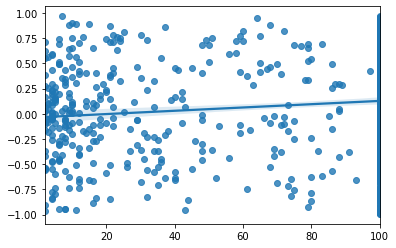

In [16]:
r2_gen = []
max_sims = []
for smiles, results in mol_results.items() :
    if 'r2_gen' in results :
        r2_gen.append(results['r2_gen'])
        max_sims.append(results['n_generated'])
normal_r2 = [i for i, r2 in enumerate(r2_gen) if r2 > -1]
sns.regplot(x=[s for i, s in enumerate(max_sims) if i in normal_r2], 
                y=[s for i, s in enumerate(r2_gen) if i in normal_r2])

<AxesSubplot:>

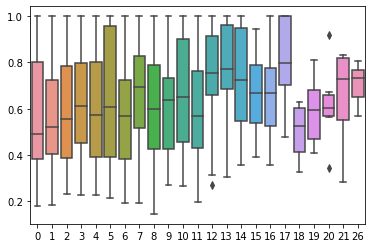

In [9]:
n_rot_bonds = []
max_sims = []
for smiles, results in mol_results.items() :
    n_rot_bonds.append(results['n_rotatable_bonds'])
    max_sims.append(results['max_sim_to_training'])
sns.boxplot(x=n_rot_bonds, y=max_sims)

<AxesSubplot:>

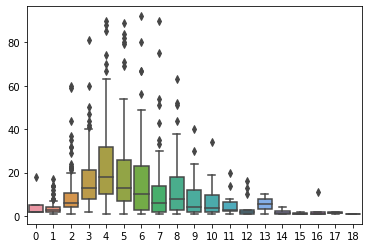

In [10]:
n_rot_bonds = []
n_actives = []
for smiles, results in mol_results.items() :
    if 'n_actives' in results :
        n_rot_bonds.append(results['n_rotatable_bonds'])
        n_actives.append(results['n_actives'])
sns.boxplot(x=n_rot_bonds, y=n_actives)

In [11]:
n_rot_bonds = []
max_sims = []
mean_rmses = []
n_generated = []
for smiles, results in mol_results.items() :
    if 'rmse_all' in results :
        n_rot_bonds.append(results['n_rotatable_bonds'])
        max_sims.append(results['max_sim_to_training'])
        mean_rmses.append(results['rmse_all'])
        n_generated.append(results['n_generated'])

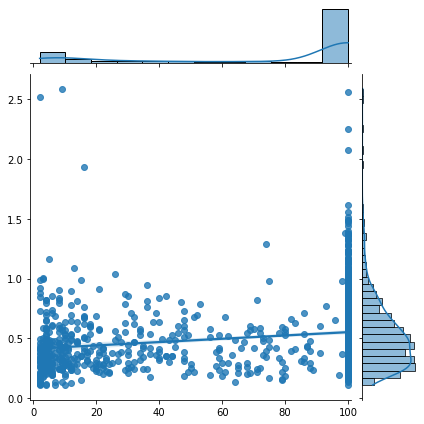

In [12]:
sns.jointplot(x=n_generated, y=mean_rmses, kind='reg', xlim=(-1, 101))

In [13]:
rot5_smiles = []
for smiles, results in mol_results.items() :
    if results['n_rotatable_bonds'] == 1 :
        rot5_smiles.append(smiles)

In [14]:
smiles = rot5_smiles[1]
mol = Chem.MolFromSmiles(smiles)

In [15]:
cel = ConfEnsembleLibrary()
cel.load_metadata()
ce = cel.load_ensemble_from_smiles(smiles, 'merged')
mol = ce.mol
AlignMolConformers(mol)
Chem.MolToXYZFile(Chem.AddHs(mol, addCoords=True), 'mol.xyz')

In [16]:
rot5_smiles = []
for smiles, results in mol_results.items() :
    if results['n_rotatable_bonds'] == 5 :
        rot5_smiles.append(smiles)

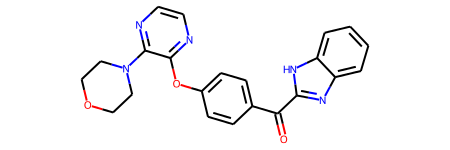

In [17]:
smiles = rot5_smiles[22]
Chem.MolFromSmiles(smiles)

In [18]:
cel = ConfEnsembleLibrary()
cel.load_metadata()
ce = cel.load_ensemble_from_smiles(smiles, 'merged')
mol = ce.mol
AlignMolConformers(mol)

In [19]:
Chem.MolToXYZFile(Chem.AddHs(mol, addCoords=True), 'mol.xyz')

In [68]:
custom_mcv = MolConfViewer(widget_size=(600, 600))
custom_mcv.view(mol)

interactive(children=(BoundedIntText(value=0, description='Conformer ID:'), Output()), _dom_classes=('widget-i…

BoundedIntText(value=0, description='Conformer ID:')

In [21]:
save_2d_depiction(mol, 'mol_for_pres.png', atom_indices=True)

In [73]:
fields = ['torsion_atoms', 'angles', 'energies', 'preds']
TorsionAnalysisResults = namedtuple("TorsionAnalysisResult", fields)

def analyze_torsion(torsion_atoms, mol) :
    data_list = mf.featurize_mol(mol)
    angles = range(-180, 180, 5)
    energies = []
    explore_data_list = []
    for angle in angles :
        dummy_mol = copy.deepcopy(mol) 
        conf = dummy_mol.GetConformer(0)
        #import pdb; pdb.set_trace()
        SetDihedralDeg(conf, *torsion_atoms, angle)

        energy = xtb_calculator.get_energy(dummy_mol)
        energies.append(energy)
        
        mol_noh = Chem.RemoveHs(dummy_mol)
        data = mf.conf_to_data(rdkit_mol=mol_noh, 
                               conf_id=0, 
                               edge_index=data_list[0].edge_index,
                               x=data_list[0].x)
        explore_data_list.append(data)
        
    model = get_model()
    batch = Batch.from_data_list(explore_data_list)
    preds = model(batch)
    preds = preds.detach().numpy().reshape(-1)
    
    results = TorsionAnalysisResults(torsion_atoms, 
                                     angles, 
                                     energies,
                                     preds)
        
    return results
        
def plot_torsion_analysis(results: TorsionAnalysisResults) :  

    torsion_atoms = results.torsion_atoms
    angles = results.angles
    energies = results.energies
    preds = results.preds
    
    bioactive_mol = copy.deepcopy(mol)
    bioactive_mol.RemoveAllConformers()
    bioactive_mol.AddConformer(mol.GetConformers()[-1], assignId=True)
    generated_mol = copy.deepcopy(mol)
    generated_mol.RemoveConformer(100)

    mol_dict = {'Bioactive': bioactive_mol,
                'Generated': generated_mol}
    ca.plot_dihedrals_histograms([torsion_atoms], mol_dict)
    
    df = pd.DataFrame({'Dihedral angle (Deg)' : angles,
                       'ARMSD prediction' : preds,
                       'Energy (kcal/mol)' : energies})
    bio_deg = GetDihedralDeg(mol.GetConformers()[-1], *torsion_atoms)
    
    with sns.plotting_context('talk') :
        sns.lineplot(data=df, 
                     x='Dihedral angle (Deg)', 
                     y='ARMSD prediction')
        plt.axvline(x=bio_deg, color='r', linestyle='-', label='Bioactive conformation')
        plt.legend(loc='upper right')
        plt.show()

        sns.lineplot(data=df, 
                     x='Dihedral angle (Deg)', 
                     y='Energy (kcal/mol)')
        plt.axvline(x=bio_deg, color='r', linestyle='-', label='Bioactive conformation')
        plt.legend(loc='upper right')
        plt.show()

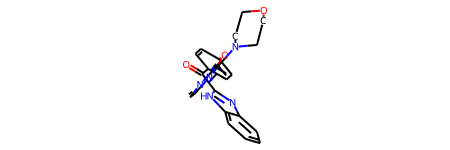

In [54]:
mol

In [63]:
gen_mol = copy.deepcopy(mol)
gen_mol.RemoveAllConformers()
gen_mol.AddConformer(mol.GetConformer(0), assignId=True)
bio_mol = copy.deepcopy(mol)
bio_mol.RemoveAllConformers()
bio_mol.AddConformer(mol.GetConformer(100), assignId=True)
AlignMol(gen_mol, bio_mol)

2.304874786658528

In [64]:
with Chem.SDWriter('gen_mol.sdf') as sdwriter :
    sdwriter.write(gen_mol)

with Chem.SDWriter('bio_mol.sdf') as sdwriter :
    sdwriter.write(bio_mol)

In [76]:
mcv.view(mol)

interactive(children=(BoundedIntText(value=0, description='Conformer ID:'), Output()), _dom_classes=('widget-i…

BoundedIntText(value=0, description='Conformer ID:')

In [44]:
rot_bonds = ca.get_rotatable_bonds_atom_idx(mol)
torsion_results = {}
mol = Chem.AddHs(mol, addCoords=True)
for torsion_atoms in rot_bonds :
    results = analyze_torsion(torsion_atoms, mol)
    torsion_results[torsion_atoms] = results

   1    -61.8682589 -0.618683E+02  0.138E+01    0.36       0.0  T
   2    -62.0156517 -0.147393E+00  0.808E+00    1.63       1.0  T
   3    -61.6376703  0.377981E+00  0.421E+00    1.57       1.0  T
   4    -62.1677877 -0.530117E+00  0.195E+00    0.76       1.0  T
   5    -62.3132420 -0.145454E+00  0.744E-01    0.45       1.0  T
   6    -62.3160370 -0.279494E-02  0.667E-01    0.43       1.0  T
   7    -62.3223972 -0.636020E-02  0.460E-01    0.38       1.0  T
   8    -62.3317674 -0.937020E-02  0.948E-02    0.37       1.0  T
   9    -62.3310379  0.729502E-03  0.144E-01    0.36       1.0  T
  10    -62.3321658 -0.112799E-02  0.854E-03    0.36       1.7  T
  11    -62.3321652  0.676305E-06  0.602E-03    0.37       2.4  T
  12    -62.3321660 -0.803022E-06  0.463E-03    0.37       3.1  T
  13    -62.3321670 -0.101649E-05  0.105E-03    0.37      13.6  T
  14    -62.3321670 -0.466411E-07  0.488E-04    0.37      29.3  T
  15    -62.3321670 -0.127802E-07  0.224E-05    0.37     637.5  T
     SCC i

KeyboardInterrupt: 

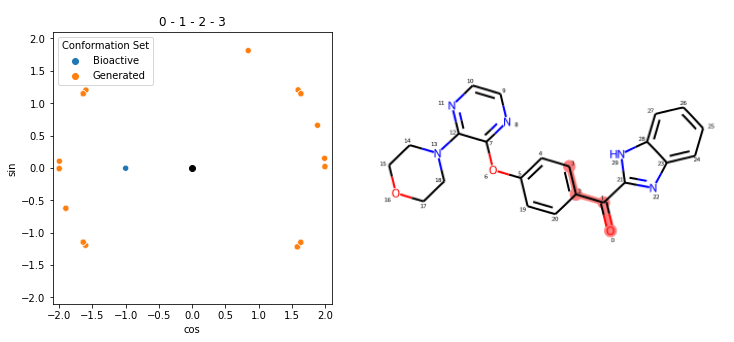

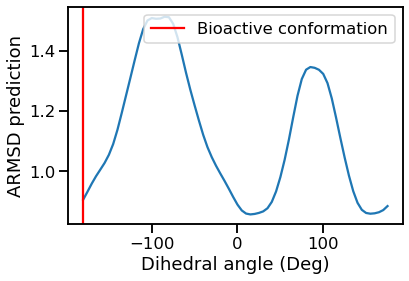

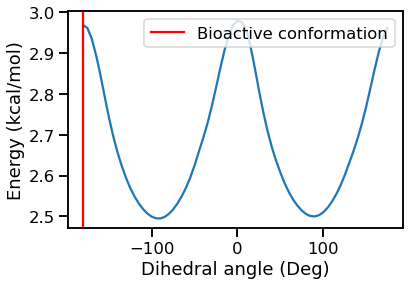

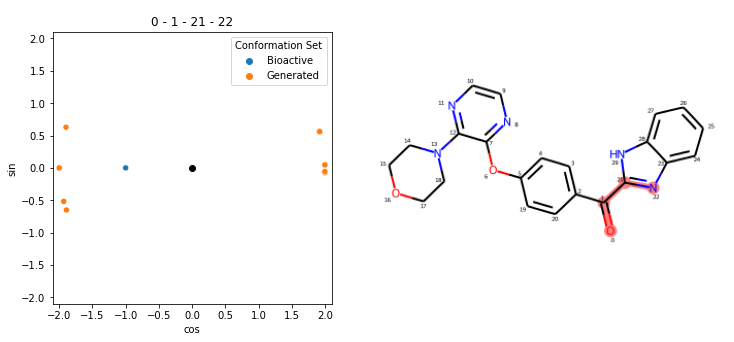

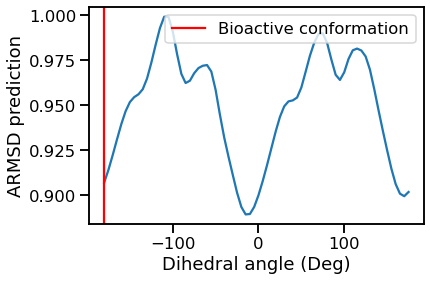

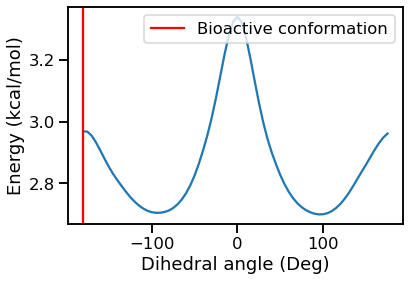

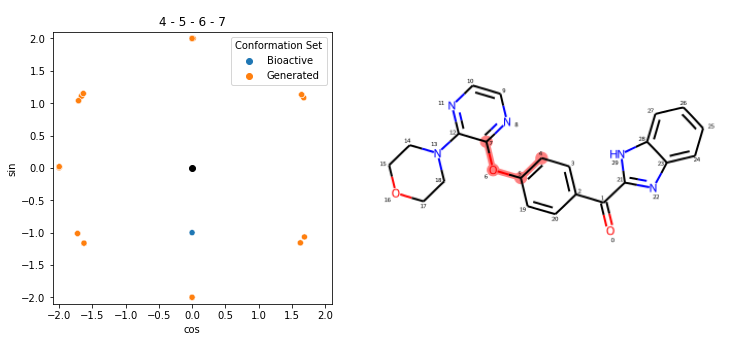

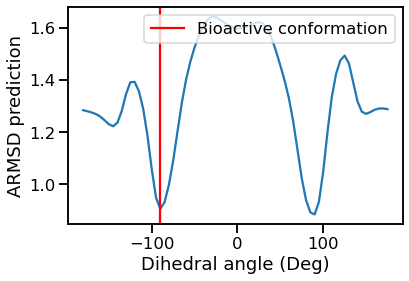

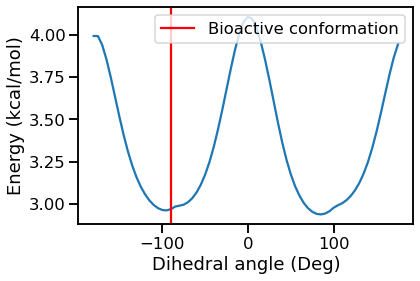

KeyError: (5, 6, 7, 8)

In [74]:
for torsion_atoms in rot_bonds :
    results = torsion_results[torsion_atoms]
    plot_torsion_analysis(results)

In [24]:
from ase.io import read, write
from ase.units import kB
from ase.optimize import LBFGS
from ase.optimize.basin import BasinHopping
from xtb.ase.calculator import XTB

In [37]:
system = read('mol.xyz')
system.calc = XTB(method="GFN2-xTB")
original_energy = system.get_potential_energy()

bh = BasinHopping(atoms=system,         # the system to optimize
                  temperature=100 * kB, # 'temperature' to overcome barriers
                  dr=0.5,               # maximal stepwidth
                  optimizer=LBFGS,      # optimizer to find local minima
                  fmax=0.1)             # maximal force for the optimizer

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 18:28:42    -2274.843381*       2.4837
LBFGS:    1 18:28:42    -2275.237055*       0.9048
LBFGS:    2 18:28:42    -2275.410031*       0.8263
LBFGS:    3 18:28:42    -2275.587939*       0.6220
LBFGS:    4 18:28:42    -2275.653087*       0.4430
LBFGS:    5 18:28:42    -2275.707048*       0.3871
LBFGS:    6 18:28:42    -2275.747354*       0.4114
LBFGS:    7 18:28:42    -2275.785657*       0.4474
LBFGS:    8 18:28:42    -2275.818459*       0.3834
LBFGS:    9 18:28:42    -2275.846164*       0.2742
LBFGS:   10 18:28:42    -2275.866351*       0.2377
LBFGS:   11 18:28:42    -2275.881476*       0.2347
LBFGS:   12 18:28:42    -2275.894358*       0.2750
LBFGS:   13 18:28:42    -2275.905415*       0.2833
LBFGS:   14 18:28:42    -2275.913513*       0.1402
LBFGS:   15 18:28:42    -2275.918912*       0.1048
LBFGS:   16 18:28:42    -2275.922766*       0.1068
LBFGS:   17 18:28:42    -2275.9259

In [38]:
original_energy

-2274.8433805582767

In [39]:
optimized_energy = system.get_potential_energy()
optimized_energy

-2275.92865524455

In [41]:
system = read('mol_optimized.xyz')
system.calc = XTB(method="GFN2-xTB")
system.get_potential_energy()

-2275.928655223503

In [26]:
write('mol_optimized.xyz', system, format='xyz')

In [27]:
from xyz2mol import read_xyz_file, xyz2mol

In [42]:
atoms, charge, xyz_coordinates = read_xyz_file('mol.xyz')
mols = xyz2mol(atoms, xyz_coordinates, charge=charge)
optimized_mol = mols[0]

In [29]:
mcv.view(mol)

interactive(children=(BoundedIntText(value=0, description='Conformer ID:'), Output()), _dom_classes=('widget-i…

BoundedIntText(value=0, description='Conformer ID:')

In [43]:
mcv.view(optimized_mol)

interactive(children=(BoundedIntText(value=0, description='Conformer ID:', max=0), Output()), _dom_classes=('w…

BoundedIntText(value=0, description='Conformer ID:', max=0)

In [44]:
torsion_results = {}
rot_bonds = ca.get_rotatable_bonds_atom_idx(optimized_mol)
for torsion_atoms in rot_bonds :
    results = analyze_torsion(torsion_atoms, optimized_mol)
    torsion_results[torsion_atoms] = results

   1    -61.8682592 -0.618683E+02  0.138E+01    0.36       0.0  T
   2    -62.0156520 -0.147393E+00  0.808E+00    1.63       1.0  T
   3    -61.6376706  0.377981E+00  0.421E+00    1.57       1.0  T
   4    -62.1677879 -0.530117E+00  0.195E+00    0.76       1.0  T
   5    -62.3132422 -0.145454E+00  0.744E-01    0.45       1.0  T
   6    -62.3160371 -0.279490E-02  0.667E-01    0.43       1.0  T
   7    -62.3223973 -0.636023E-02  0.460E-01    0.38       1.0  T
   8    -62.3317676 -0.937025E-02  0.948E-02    0.37       1.0  T
   9    -62.3310381  0.729495E-03  0.144E-01    0.36       1.0  T
  10    -62.3321660 -0.112798E-02  0.854E-03    0.36       1.7  T
  11    -62.3321654  0.676312E-06  0.602E-03    0.37       2.4  T
  12    -62.3321662 -0.803101E-06  0.463E-03    0.37       3.1  T
  13    -62.3321672 -0.101645E-05  0.105E-03    0.37      13.6  T
  14    -62.3321672 -0.466410E-07  0.488E-04    0.37      29.3  T
  15    -62.3321672 -0.127798E-07  0.224E-05    0.37     637.5  T
     SCC i

KeyboardInterrupt: 

In [52]:
numbers = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
numbers = np.array(numbers)
conf = mol.GetConformer(0)
positions = conf.GetPositions()
print(numbers)
print(positions[:5])
print(len(positions))

[8 6 6 6 6 6 8 6 7 6 6 7 6 7 6 6 8 6 6 6 6 6 7 6 6 6 6 6 6 7]
[[ 1.4382 -0.4501  2.2336]
 [ 2.3915 -1.0206  2.7412]
 [ 2.7555 -0.7165  4.1862]
 [ 3.8553 -1.3508  4.8098]
 [ 4.1782 -1.0642  6.1349]]
30


In [53]:
from xtb.libxtb import VERBOSITY_MINIMAL
from xtb.interface import Calculator, Param
calc = Calculator(Param.GFN2xTB, numbers, positions)
calc.set_verbosity(VERBOSITY_MINIMAL)
res = calc.singlepoint()
energy = res.get_energy()

   1    -59.4270073 -0.594270E+02  0.152E+01    1.63       0.0  T
   2    -59.2740966  0.152911E+00  0.954E+00    0.74       1.0  T
   3    -57.4894552  0.178464E+01  0.645E+00    0.64       1.0  T
   4    -59.6666974 -0.217724E+01  0.272E+00    2.26       1.0  T
   5    -59.8956405 -0.228943E+00  0.120E+00    1.01       1.0  T
   6    -59.8326931  0.629474E-01  0.162E+00    0.43       1.0  T
   7    -59.9099978 -0.773046E-01  0.113E+00    0.84       1.0  T
   8    -59.9459977 -0.359999E-01  0.806E-01    0.65       1.0  T
   9    -59.9629898 -0.169921E-01  0.566E-01    0.68       1.0  T
  10    -59.9715682 -0.857845E-02  0.418E-01    0.78       1.0  T
  11    -59.9762347 -0.466643E-02  0.317E-01    0.77       1.0  T
  12    -59.9815975 -0.536286E-02  0.956E-02    0.76       1.0  T
  13    -59.9800551  0.154245E-02  0.184E-01    0.74       1.0  T
  14    -59.9818289 -0.177378E-02  0.573E-02    0.75       1.0  T
  15    -59.9820185 -0.189614E-03  0.998E-03    0.76       1.8  T
  16    -5

In [34]:
numbers = [atom.GetAtomicNum() for atom in optimized_mol.GetAtoms()]
numbers = np.array(numbers)
conf = optimized_mol.GetConformer(0)
positions = conf.GetPositions()
print(numbers)
print(positions[:5])
print(len(positions))

[8 6 6 6 6 6 8 6 7 6 6 7 6 7 6 6 8 6 6 6 6 6 7 6 6 6 6 6 6 7 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 1.51827674 -0.52797665  2.17785406]
 [ 2.45640028 -1.08084519  2.73467501]
 [ 2.81823761 -0.79916803  4.13889515]
 [ 3.89664171 -1.40393472  4.78420882]
 [ 4.16390528 -1.11790966  6.10647694]]
49


In [50]:
from xtb.libxtb import VERBOSITY_MINIMAL
from xtb.interface import Calculator, Param
calc = Calculator(Param.GFN2xTB, numbers, positions)
#calc.set_verbosity(VERBOSITY_MINIMAL)
res = calc.singlepoint()
energy = res.get_energy()

   1            NaN           NaN        NaN     NaN       0.0  T
   2            NaN           NaN        NaN     NaN  100000.0  T
   3            NaN           NaN        NaN     NaN  100000.0  T
   4            NaN           NaN        NaN     NaN  100000.0  T
   5            NaN           NaN        NaN     NaN  100000.0  T
   6            NaN           NaN        NaN     NaN  100000.0  T
   7            NaN           NaN        NaN     NaN  100000.0  T
   8            NaN           NaN        NaN     NaN  100000.0  T
   9            NaN           NaN        NaN     NaN  100000.0  T
  10            NaN           NaN        NaN     NaN  100000.0  T
  11            NaN           NaN        NaN     NaN  100000.0  T
  12            NaN           NaN        NaN     NaN  100000.0  T
  13            NaN           NaN        NaN     NaN  100000.0  T
  14            NaN           NaN        NaN     NaN  100000.0  T
  15            NaN           NaN        NaN     NaN  100000.0  T
  16      

In [ ]:
for torsion_atoms in rot_bonds :
    results = torsion_results[torsion_atoms]
    plot_torsion_analysis(results)

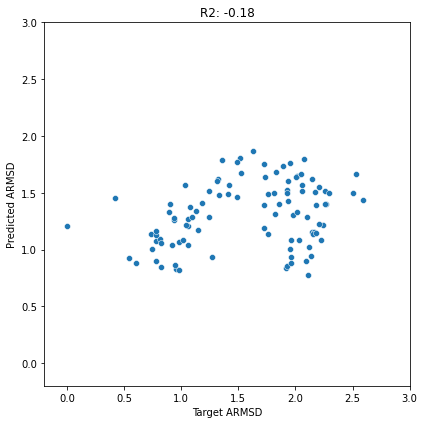

In [66]:
x = conf_results[smiles]['targets']
y = conf_results[smiles]['preds']
r2 = r2_score(x, y)
plt.figure(figsize=(6, 6))
sns.scatterplot(x=x, y=y)
plt.xlim(-0.2, 3)
plt.ylim(-0.2, 3)
plt.xlabel('Target ARMSD')
plt.ylabel('Predicted ARMSD')
plt.title(f'R2: {r2:.2f}')
plt.tight_layout()
plt.savefig('large_mol_regression.png', dpi=300)

In [26]:
flexible_smiles = []
for smiles, results in mol_results.items() :
    if results['n_rotatable_bonds'] == 18 :
        flexible_smiles.append(smiles)

In [27]:
flexible_smiles

['CSCC[C@H](NC(=O)[C@H](CC(=O)[O-])NC(C)=O)C(=O)N[C@@H](CCC(N)=O)C(=O)N[C@H](CO)CC(=O)[O-]',
 'CCc1cc(C[C@H](NC(C)=O)C(=O)NCCCCC(=O)N[C@@H](CCSC)C(=O)[O-])ccc1N(C(=O)C(=O)[O-])c1ccccc1C(=O)[O-]',
 'CC(C)NC(=O)COCCOCCNC(=O)[C@H](C)NC(=O)[C@@H](O)[C@H]([NH3+])Cc1ccc(OCc2ccccc2)cc1',
 'NC(=O)[C@H](CCCCNC(=O)[C@@H](Cc1ccc(C(=O)c2ccccc2)cc1)NC(=O)CCC1CCCCC1)NC(=O)/C=C/C(=O)[O-]',
 'CCCCCCC[C@@H]1S[C@@H](CC(=O)N(Cc2ccccc2)Cc2ccccc2)C(=O)N1CCCCc1ccc(C(=O)[O-])cc1',
 'CC(C)C[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@@H]([NH3+])CC(=O)[O-])[C@@H](C)O)C(=O)[O-]']

In [28]:
cel = ConfEnsembleLibrary()
cel.load_metadata()

In [29]:
pmp = PDBBindMetadataProcessor()
table = pmp.get_master_dataframe()

In [30]:
smiles = flexible_smiles[5]
ce = cel.load_ensemble_from_smiles(smiles, load_dir='merged')
test_mol = ce.mol
pdb_id = ce.mol.GetProp('PDB_ID')
table[table['PDB code'] == pdb_id]

,PDB code,resolution,release year_x,-logKd/Ki,Kd/Ki,reference,ligand name,activity_list,sep,value,units,release year_y,Uniprot ID,protein name,active


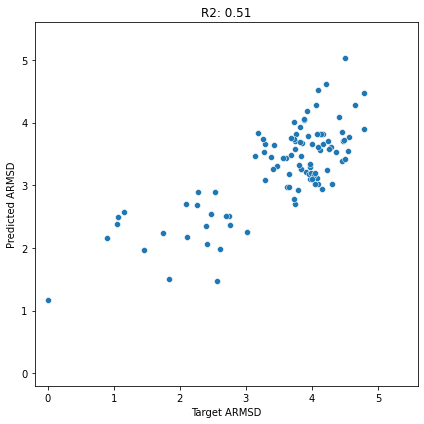

In [31]:
x = conf_results[smiles]['targets']
y = conf_results[smiles]['preds']
r2 = r2_score(x, y)
plt.figure(figsize=(6, 6))
sns.scatterplot(x=x, y=y)
plt.xlim(-0.2, 5.6)
plt.ylim(-0.2, 5.6)
plt.xlabel('Target ARMSD')
plt.ylabel('Predicted ARMSD')
plt.title(f'R2: {r2:.2f}')
plt.tight_layout()
plt.savefig('large_mol_regression.png', dpi=300)

In [32]:
save_2d_depiction(test_mol, 'generated_ranking_results/test_mol.png')

AlignMolConformers(test_mol)
mcv.view(test_mol)

interactive(children=(BoundedIntText(value=0, description='Conformer ID:'), Output()), _dom_classes=('widget-i…

BoundedIntText(value=0, description='Conformer ID:')

In [33]:
sdwriter = Chem.SDWriter('generated_ranking_results/mol.sdf')
for conf in test_mol.GetConformers() :
    sdwriter.write(test_mol, confId=conf.GetId())
sdwriter.close()

In [34]:
train_mol = get_most_similar_mol_in_train(test_mol, train_fps)
pdb_id = train_mol.GetProp('PDB_ID')
table[table['PDB code'] == pdb_id]

mcv.view(train_mol)

Tanimoto similarity:  0.6190476190476191


interactive(children=(BoundedIntText(value=0, description='Conformer ID:'), Output()), _dom_classes=('widget-i…

BoundedIntText(value=0, description='Conformer ID:')

In [35]:
mcs = rdFMCS.FindMCS([test_mol, train_mol])
core = Chem.MolFromSmarts(mcs.smartsString)

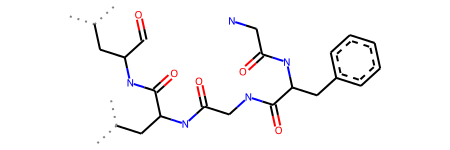

In [36]:
core

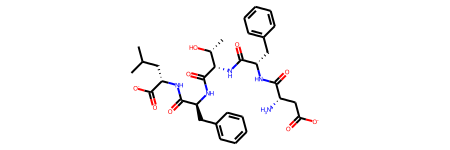

In [37]:
def mol_3d_to_2d(mol) :
    copy_mol = copy.deepcopy(mol)
    copy_mol.RemoveAllConformers()
    return copy_mol
copy_1 = mol_3d_to_2d(ce.mol)
copy_1

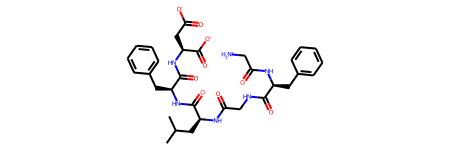

In [38]:
copy_2 = mol_3d_to_2d(train_mol)
copy_2

In [39]:
query_match = copy_1.GetSubstructMatch(core)
template_match = copy_2.GetSubstructMatch(core)
AllChem.Compute2DCoords(copy_1)
AllChem.Compute2DCoords(copy_2)
rms = AlignMol(copy_1, copy_2, atomMap=list(zip(query_match,template_match)))
save_2d_depiction(copy_1, 'generated_ranking_results/mol1.png')
save_2d_depiction(copy_2, 'generated_ranking_results/mol2.png')

In [40]:
model = get_model()
model.eval()
import torch
with torch.no_grad() :
    model.show_atomic_contributions(test_mol, suffix='Test', savedir='generated_ranking_results/')
    model.show_atomic_contributions(train_mol, suffix='Similar_train', savedir='generated_ranking_results/')

In [41]:
data_list = mf.featurize_mol(test_mol)
batch = Batch.from_data_list(data_list)
ac = model.get_atomic_contributions(batch).detach().numpy()
grouped_ac = ac.reshape(test_mol.GetNumConformers(), test_mol.GetNumAtoms())
preds = model(batch)
preds = preds.detach().numpy().reshape(-1)

In [42]:
bioactive_mol = copy.deepcopy(test_mol)
bioactive_mol.RemoveAllConformers()
bioactive_mol.AddConformer(test_mol.GetConformer(100), assignId=True)
generated_mol = copy.deepcopy(test_mol)
generated_mol.RemoveConformer(100)

mol_dict = {'Bioactive': bioactive_mol,
            'Generated': generated_mol}

In [43]:
preds.argsort()

array([100,   3,  18,  63,  77,  94,  47,  38,  54,  57,  30,  60,  14,
        78,  46,  91,  86,  92,  37,  28,  16,  59,  89,  71,  23,  62,
         7,  95,  65,  67,  70,   9,  50,  84,  48,  96,  44,  34,  33,
        11,   1,  24,  53,  10,  90,  81,  45,  17,  85,  41,  69,  22,
        87,  27,  26,  49,  58,  97,  42,  79,  29,  12,  82,  80,  76,
        75,   5,  40,  55,  99,  52,  15,  72,   4,  88,  39,   8,  36,
        66,  74,  31,   2,   0,  20,  35,   6,  51,  73,  93,  43,  83,
        19,  25,  13,  68,  64,  98,  32,  21,  61,  56])

In [44]:
import importlib
import ConfScorer
importlib.reload(ConfScorer)
ca = ConfScorer.ConfAnalyzer()

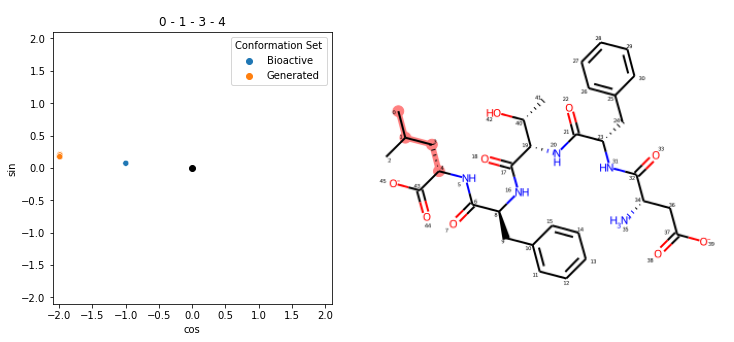

<Figure size 432x288 with 0 Axes>

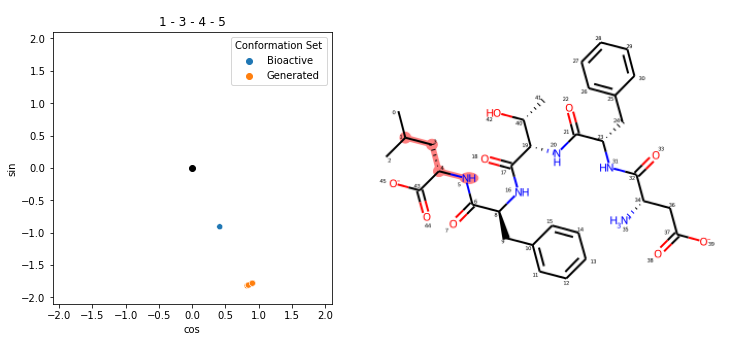

<Figure size 432x288 with 0 Axes>

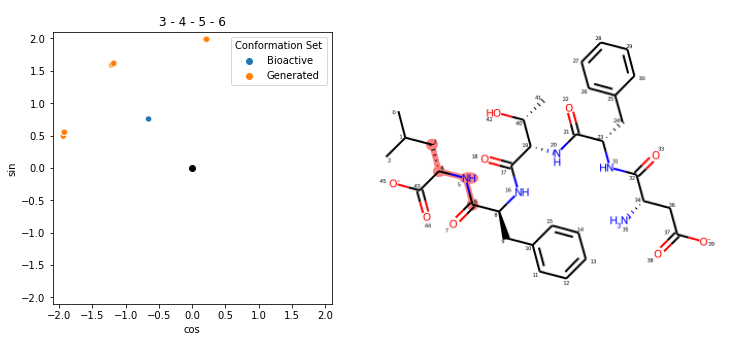

<Figure size 432x288 with 0 Axes>

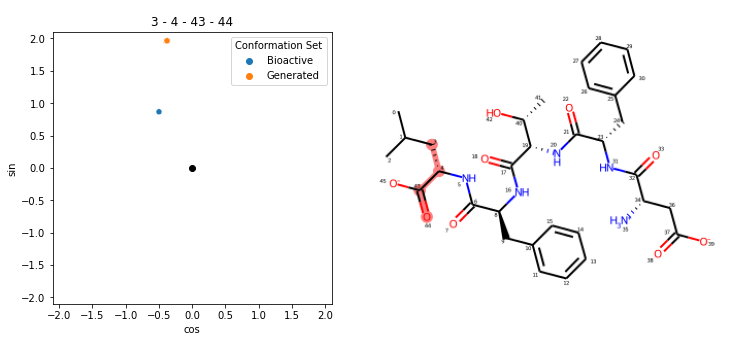

<Figure size 432x288 with 0 Axes>

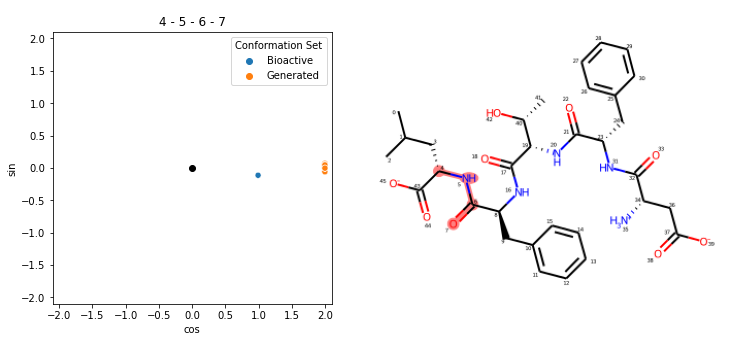

<Figure size 432x288 with 0 Axes>

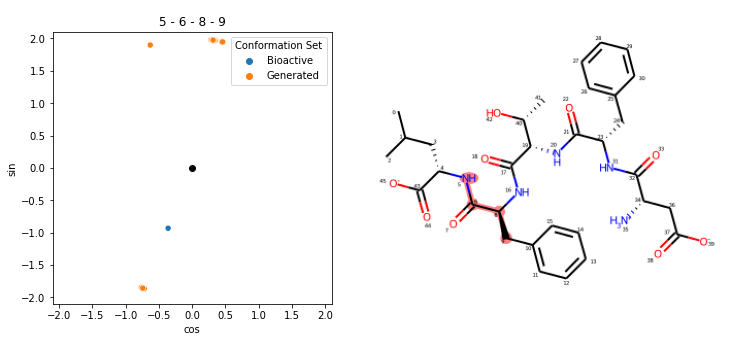

<Figure size 432x288 with 0 Axes>

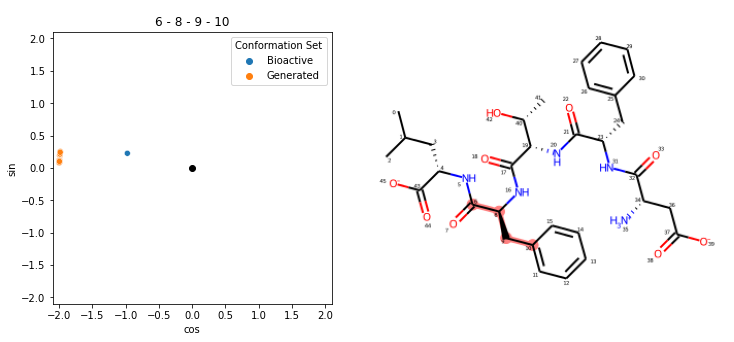

<Figure size 432x288 with 0 Axes>

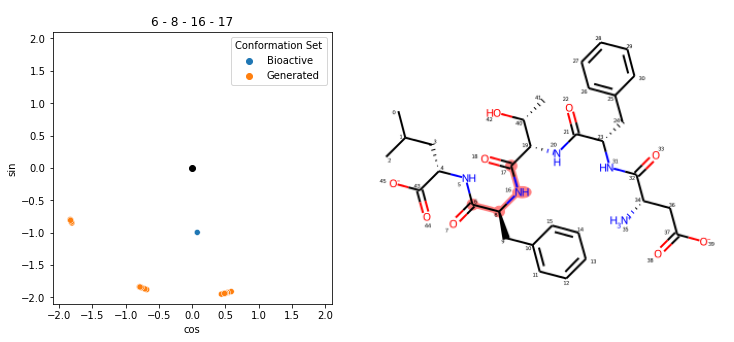

<Figure size 432x288 with 0 Axes>

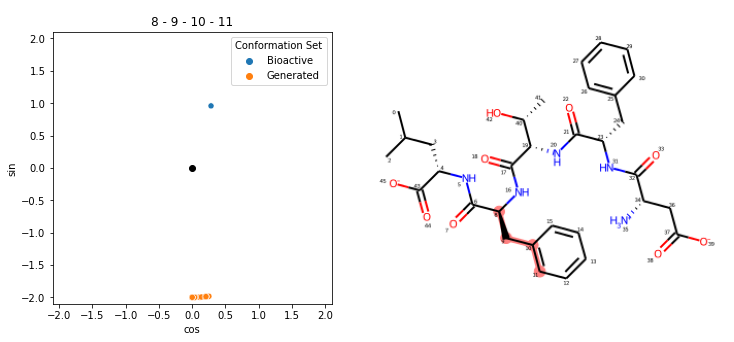

<Figure size 432x288 with 0 Axes>

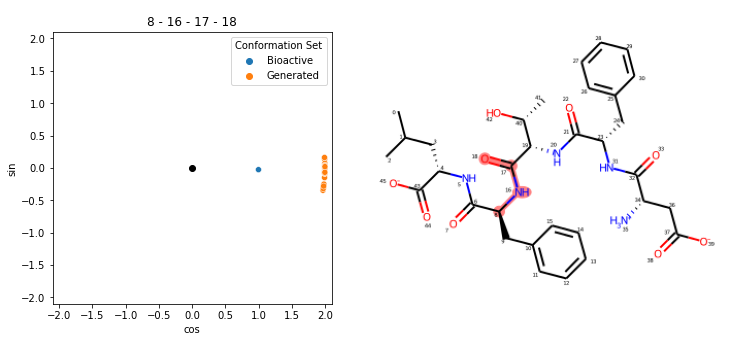

<Figure size 432x288 with 0 Axes>

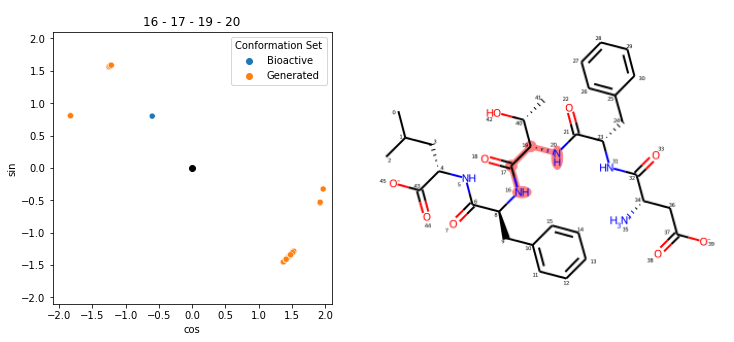

<Figure size 432x288 with 0 Axes>

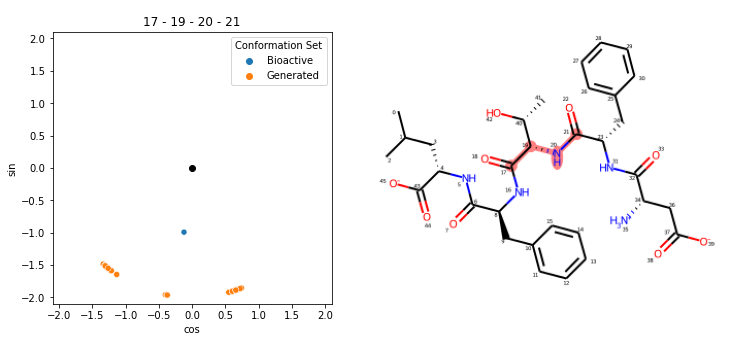

<Figure size 432x288 with 0 Axes>

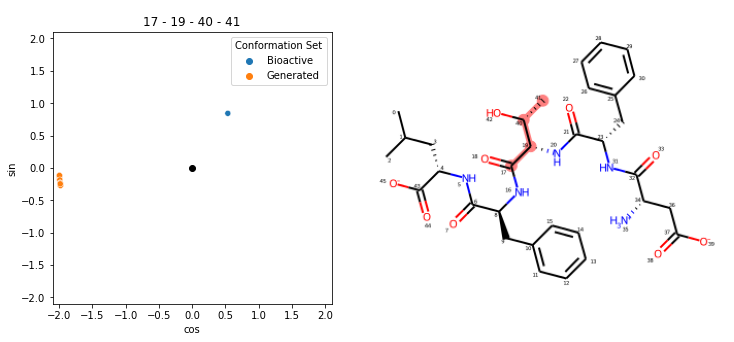

<Figure size 432x288 with 0 Axes>

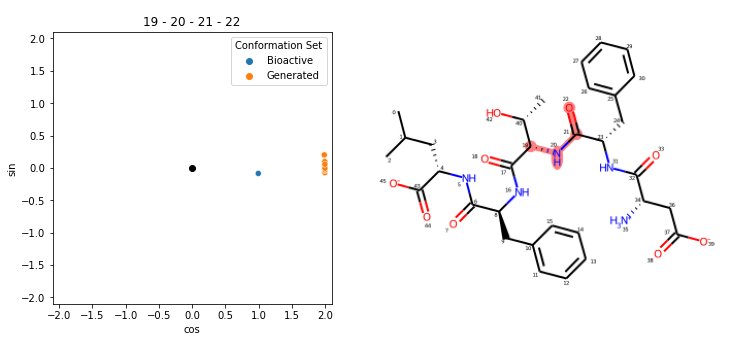

<Figure size 432x288 with 0 Axes>

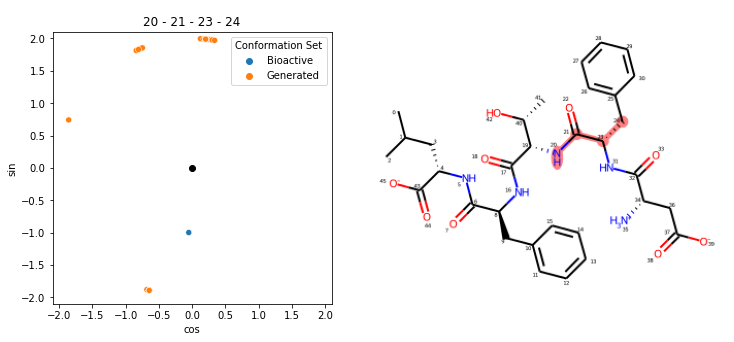

<Figure size 432x288 with 0 Axes>

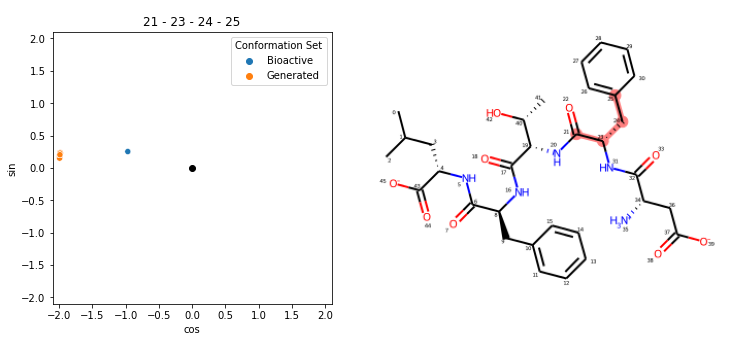

<Figure size 432x288 with 0 Axes>

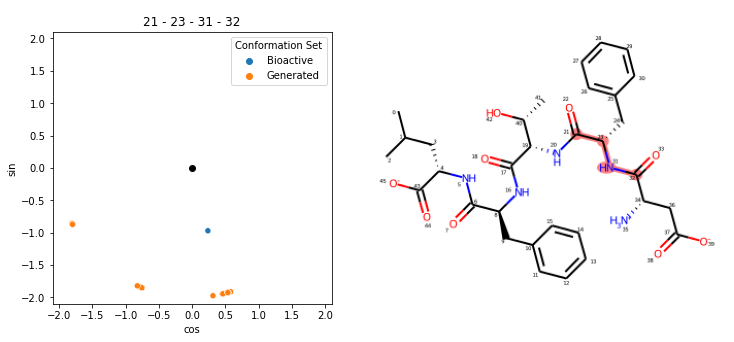

<Figure size 432x288 with 0 Axes>

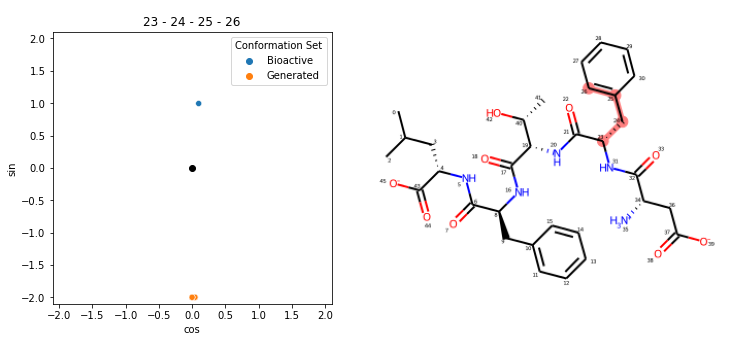

<Figure size 432x288 with 0 Axes>

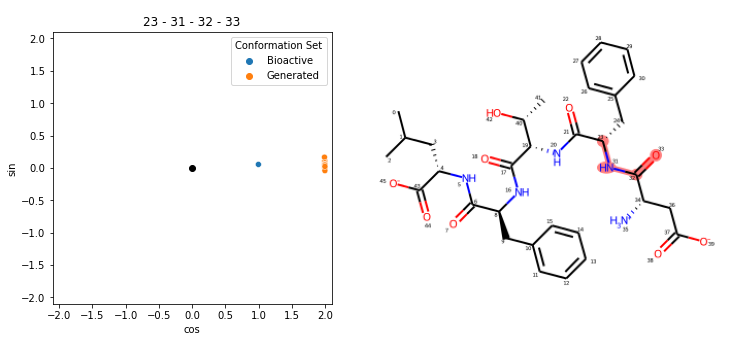

<Figure size 432x288 with 0 Axes>

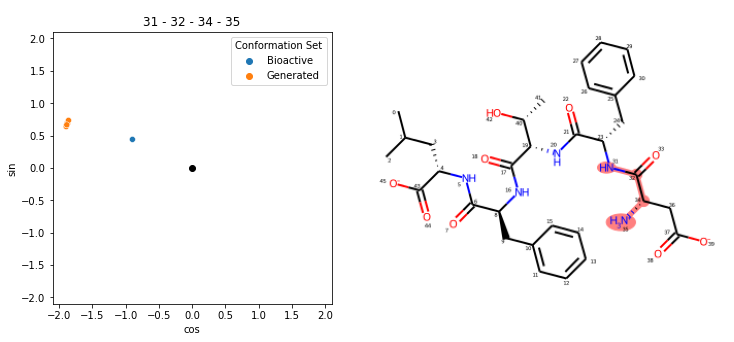

<Figure size 432x288 with 0 Axes>

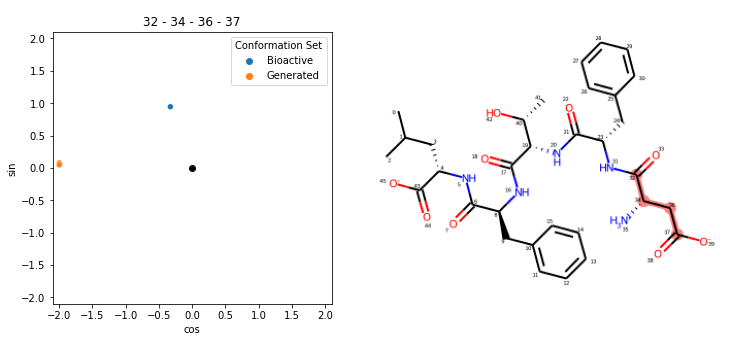

<Figure size 432x288 with 0 Axes>

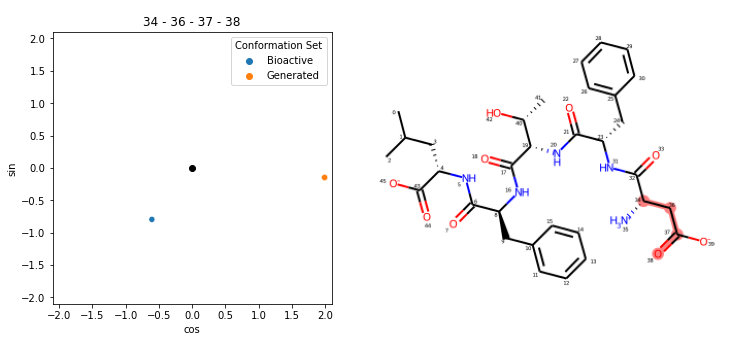

<Figure size 432x288 with 0 Axes>

In [45]:
dihedrals_atom_ids = ca.get_rotatable_bonds_atom_idx(generated_mol)
ca.plot_dihedrals_histograms(dihedrals_atom_ids=dihedrals_atom_ids, mol_dict=mol_dict)

In [46]:
assert True == False

AssertionError: 

In [ ]:
grouped_ac.min(axis=0)

In [ ]:
rot_bonds = ca.get_rotatable_bonds_atom_idx(test_mol)

In [ ]:
cosins = np.empty((0, generated_mol.GetNumConformers()))
for dihedral_indexes in rot_bonds :
    dihedrals = ca.get_conformers_dihedrals_deg(generated_mol, *dihedral_indexes)
    dihedrals_rad = np.deg2rad(dihedrals)
    coss = np.cos(dihedrals_rad)
    sins = np.sin(dihedrals_rad)
    cosins = np.vstack([cosins, coss, sins])

In [ ]:
data_list = mf.featurize_mol(generated_mol)
batch = Batch.from_data_list(data_list)
ac = model.get_atomic_contributions(batch).detach().numpy()
grouped_ac = ac.reshape(generated_mol.GetNumConformers(), generated_mol.GetNumAtoms())
preds = model(batch)
preds = preds.detach().numpy().reshape(-1)

In [ ]:
cosins = cosins.transpose()

In [ ]:
cosins.shape

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(cosins, preds)

In [ ]:
lr.coef_.max()

In [ ]:
lr.coef_.argsort()

In [ ]:
lr.coef_.min()

In [ ]:
rot_bonds

In [ ]:
rot_bonds[21]

In [ ]:
plt.plot(lr.coef_)

In [ ]:
lr_preds = lr.predict(cosins)

In [ ]:
plt.plot(lr_preds - preds)

In [ ]:
dihedrals_i = ca.get_conformers_dihedrals_deg(test_mol, 16, 17, 19, 20)
dihedrals_j = ca.get_conformers_dihedrals_deg(test_mol, 20, 21, 23, 24)
plt.figure(figsize=(10,10))
sns.scatterplot(x=dihedrals_i, y=dihedrals_j, hue=preds.reshape(-1).detach().numpy())
plt.show()

In [ ]:
dihedrals_i = ca.get_conformers_dihedrals_deg(test_mol, 16, 17, 19, 20)
dihedrals_j = ca.get_conformers_dihedrals_deg(test_mol, 20, 21, 23, 24)
for i in range(grouped_ac.shape[1]) :
    atom_contributions = grouped_ac[:, i]
    sns.scatterplot(x=dihedrals_i, y=dihedrals_j, hue=atom_contributions)
    plt.title(i)
    plt.show()

In [ ]:
dihedrals_atom_ids = [(27, 28, 29, 30), (33, 27, 28, 29), (36, 22, 23, 24)]
ca.plot_dihedrals_histograms(dihedrals_atom_ids=dihedrals_atom_ids, 
                             mol_dict=mol_dict)

In [ ]:
data_list = mf.featurize_mol(train_mol)
batch = Batch.from_data_list(data_list)
ac = model.get_atomic_contributions(batch).detach().numpy()
grouped_ac = ac.reshape(train_mol.GetNumConformers(), train_mol.GetNumAtoms())

In [ ]:
bioactive_mol = copy.deepcopy(train_mol)
bioactive_mol.RemoveAllConformers()
bioactive_mol.AddConformer(train_mol.GetConformer(100), assignId=True)
generated_mol = copy.deepcopy(train_mol)
generated_mol.RemoveConformer(100)

mol_dict = {'Bioactive': bioactive_mol,
            'Generated': generated_mol}

In [ ]:
dihedrals = ca.get_conformers_dihedrals_deg(train_mol, 3, 4, 5, 43)
for i in range(grouped_ac.shape[1]) :
    atom_contributions = grouped_ac[:, i]
    sns.scatterplot(x=dihedrals, y=atom_contributions)
    plt.title(i)
    plt.show()

In [ ]:
dihedrals_atom_ids = [(3, 4, 5, 43)]
ca.plot_dihedrals_histograms(dihedrals_atom_ids=dihedrals_atom_ids, 
                             mol_dict=mol_dict)

In [ ]:
targets = mf.get_bioactive_rmsds(train_mol)
preds = model(batch)

In [ ]:
x = targets.detach().numpy()
y = preds.reshape(-1).detach().numpy()
r2 = r2_score(x, y)
plt.figure(figsize=(6, 6))
sns.scatterplot(x=x, y=y)
plt.xlim(-0.2, 6.2)
plt.ylim(-0.2, 6.2)
plt.xlabel('Target ARMSD')
plt.ylabel('Predicted ARMSD')
plt.title(f'R2: {r2:.2f}')
plt.tight_layout()
plt.savefig('large_mol_regression_train.png', dpi=300)

In [ ]:
sdwriter = Chem.SDWriter('test_mol.sdf')
for conf_id in [99, 100] :
    sdwriter.write(test_mol, confId=conf_id)
sdwriter.close()

In [ ]:
sdwriter = Chem.SDWriter('train_mol.sdf')
for conf_id in [99, 100] :
    sdwriter.write(test_mol, confId=conf_id)
sdwriter.close()

# Largest regression RMSE

In [ ]:
rmses = []
for smiles, results in conf_results.items() :
    rmses.extend(results['rmse'])

In [ ]:
max_rmse_idx = np.argmax(rmses)

In [ ]:
max_rmse = rmses[max_rmse_idx]
max_rmse

In [ ]:
for smiles, results in conf_results.items() :
    if max_rmse in results['rmse'] :
        print(smiles)
        break

In [ ]:
ce = cel.load_ensemble_from_smiles(smiles, load_dir='merged')
pdb_id = ce.mol.GetProp('PDB_ID')
table[table['PDB code'] == pdb_id]

In [ ]:
sns.scatterplot(x=results['targets'], y=results['preds'])
plt.xlim(-0.2)
plt.ylim(-0.2)

In [ ]:
properties = {'RMSE' : results['rmse'],
              'ARMSD' : results['targets'],
              'Predicted ARMSD' : results['preds'],
              'UFF Energy' : results['energies']}
conf_id_slider = mcv.view(ce.mol,
                         properties=properties)

In [ ]:
mean_rmses = []
for smiles, results in conf_results.items() :
    mol_res = mol_results[smiles]
    if 'rmse_all' in mol_res :
        mean_rmse = mol_res['rmse_all']
        mean_rmses.append(mean_rmse)

In [ ]:
max_rmse_idx = np.argmax(mean_rmses)

In [ ]:
max_rmse = mean_rmses[max_rmse_idx]

In [ ]:
for smiles, results in conf_results.items() :
    mol_res = mol_results[smiles]
    if 'rmse_all' in mol_res :
        mean_rmse = mol_res['rmse_all']
        if max_rmse == mean_rmse :
            print(smiles)
            break

In [ ]:
ce = cel.load_ensemble_from_smiles(smiles, load_dir='merged')
pdb_id = ce.mol.GetProp('PDB_ID')
table[table['PDB code'] == pdb_id]

In [ ]:
sns.scatterplot(x=results['targets'], y=results['preds'])
plt.xlim(-0.2)
plt.ylim(-0.2)

In [ ]:
properties = {'RMSE' : results['rmse'],
              'ARMSD' : results['targets'],
              'Predicted ARMSD' : results['preds'],
              'UFF Energy' : results['energies']}
conf_id_slider = mcv.view(ce.mol,
                         properties=properties)

In [ ]:
test_fp = AllChem.GetMorganFingerprint(ce.mol, 3, useChirality=True)
sims = []
for train_fp in train_fps :
    dice_sim = DataStructs.TanimotoSimilarity(test_fp, train_fp)
    sims.append(dice_sim)
max_sim = max(sims)
max_sim_idx = np.argmax(sims)
sim_smiles = train_smiles[max_sim_idx]

sim_ce = cel.load_ensemble_from_smiles(sim_smiles, load_dir='merged')
pdb_id = sim_ce.mol.GetProp('PDB_ID')
table[table['PDB code'] == pdb_id]

mf = MoleculeFeaturizer()
model = get_model()
model.eval()
data_list = mf.featurize_mol(sim_ce.mol)
targets = mf.get_bioactive_rmsds(sim_ce.mol).numpy()

batch = Batch.from_data_list(data_list)
preds = model(batch).detach().numpy().squeeze()
errors = np.abs(targets - preds)

properties = {'RMSE' : errors,
              'ARMSD' : targets,
              'Predicted ARMSD' : preds,
              'UFF Energy' : batch.energy.numpy()}
mcv.view(sim_ce.mol,
         properties=properties)

In [ ]:
new_mol = copy.deepcopy(sim_ce.mol)

In [ ]:
d2d = rdMolDraw2D.MolDraw2DCairo(700, 700)
d2d.drawOptions().addAtomIndices=True
d2d.DrawMolecule(new_mol)
d2d.FinishDrawing()
d2d.WriteDrawingText('mol.png') 

In [ ]:
AlignMolConformers(new_mol, atomIds=list(range(2, 34)))

In [ ]:
mcv.view(new_mol,
         properties=properties)

In [ ]:
batch

In [ ]:
mcs = rdFMCS.FindMCS([ce.mol, sim_ce.mol])

In [ ]:
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol
mol_with_atom_index(core)

In [ ]:
mol_copy = copy.deepcopy(ce.mol)
mol_copy.RemoveAllConformers()
mol_with_atom_index(mol_copy)

In [ ]:
core = Chem.MolFromSmarts(mcs.smarts)
mol1_atoms = ce.mol.GetSubstructMatches(core)[0]
mol2_atoms = sim_ce.mol.GetSubstructMatches(core)[0]
atom_map = list(zip(mol1_atoms, mol2_atoms))

In [ ]:
for i in range(ce.mol.GetNumConformers()) :
    AlignMol(ce.mol, sim_ce.mol, i, 3, atomMap=atom_map)

In [ ]:
properties = {'RMSE' : results['rmse'],
              'ARMSD' : results['targets'],
              'Predicted ARMSD' : results['preds'],
              'UFF Energy' : results['energies']}
mcv.view(ce.mol, properties)
mcv.view(sim_ce.mol)